### Problema de negócio: Prever o Costumer Churn de uma operadora de Telecom, onde utiliza a regra 80/20  (20% dos clientes geram 80% da receita) 
### Objetivo: Criar modelo de ML p prever se um cliente pode cancelar seu plano e qual a probabilidade, utilizando Regressão Logística


### Carregando Dados e as Bibliotecas necessárias

In [131]:
#Manipulação de dados
import pandas as pd

#Computação científica
import numpy as np

#Plotagem de gráficos
import matplotlib.pyplot as plt

#Filtro de Warnings
import warnings 
warnings.filterwarnings("ignore")

#Machine Learning 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2, f_classif 


In [132]:
train = pd.read_csv('C:/Users/CintiaDuarte/Desktop/Projetos DS/Projeto4/projeto4_telecom_treino.csv', encoding = 'latin-1')
test = pd.read_csv('C:/Users/CintiaDuarte/Desktop/Projetos DS/Projeto4//projeto4_telecom_teste.csv', encoding = 'latin-1')

### Compreendendo as variáveis do Dataset e criando o Dicionário de Dados

In [133]:
#removendo a primeira coluna Unnamed: 0
# segunda opção de código: train.drop("Unnamed: 0", axis = 1, inplace = True)

train = train.iloc[:, 1:]
test = test.iloc[:, 1:]

In [155]:
descricao = ['Estado','Quantidade de dias em que a conta está ativa', 'Código da área', 'Se é um plano internacional', 'Se tem plano de voz', 'Número de mensagens de voz realizadas', 'Total de minutos utilizados duarante o dia', \
             'Total de ligações realizadas durante o dia', 'Total pago por chamadas realizadas durante o dia', 'Total de minutos utilizados no início da noite', 'Total de ligações realizadas no início da noite', \
             'Total pago por chamadas realizadas no ínicio da noite', 'Total de minutos utilizados noite a dentro', 'Total de ligações realizadas noite a dentro', 'Total pago por chamadas realizadas noite a dentro', \
             'Total de minutos utilizados em ligações internacionais', 'Total de ligações internacionais realizadas', 'Total pago por chamadas internacionais', ' Número de chamadas feitas para o call center da empresa', \
            'Se o cliente cancelou ou não - varivável target']

tipo_avaliado = ['Categórica', 'Numérica', 'Categórica', 'Categórica', 'Categórica','Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', 'Numérica', \
                'Numérica', 'Numérica', 'Numérica','Categórica']
            
pd.set_option('max_colwidth', 100)# ajustando o tamanho das colunas

dict_dados = {'Variável': [train.columns[i] for i in range(20)], 
            'Descrição': descricao,
            'Tipo Avaliado': tipo_avaliado,
            'Tipo de dados defull (dtypes)' : [train.dtypes[i] for i in range(20)]} 

dict_dados = pd.DataFrame.from_dict(dict_dados, orient='index') #Transaformando o dicionário de dados (par de chave e valor) em dataframe
dict_dados = dict_dados.transpose() 

In [156]:
dict_dados

,Variável,Descrição,Tipo Avaliado,Tipo de dados defull (dtypes)
0,account_length,Estado,Categórica,int64
1,area_code,Quantidade de dias em que a conta está ativa,Numérica,int32
2,international_plan,Código da área,Categórica,int64
3,voice_mail_plan,Se é um plano internacional,Categórica,int64
4,number_vmail_messages,Se tem plano de voz,Categórica,int64
5,total_day_minutes,Número de mensagens de voz realizadas,Numérica,float64
6,total_day_calls,Total de minutos utilizados duarante o dia,Numérica,int64
7,total_day_charge,Total de ligações realizadas durante o dia,Numérica,float64
8,total_eve_minutes,Total pago por chamadas realizadas durante o dia,Numérica,float64
9,total_eve_calls,Total de minutos utilizados no início da noite,Numérica,int64


### Data Munging - Manipulação dos dados

In [21]:
#dimensões do dado de treino e teste
print(train.shape)
print(test.shape)

(3333, 20)
(1667, 20)


In [ ]:
#verificando valores missing
print(train.isna().sum()) 

In [31]:
train.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [134]:
#removendo o texto da variável area_code
train["area_code"] = train["area_code"].str.slice(10, 13, 1)
test["area_code"] = test["area_code"].str.slice(10, 13, 1)

In [135]:
train["area_code"] = train["area_code"].astype(int)
test["area_code"] = test["area_code"].astype(int)

In [136]:
#substituindo as strings das variáveis categórias para se trabalhar apenas com dados numéricos
# segunda opção de código: train = train.replace('no', 0).replace('yes',1)
# Terceira opção: dictYesNo = {'yes' : 1, 'no' : 0} 
# train['international_plan_num'] = train.international_plan.map(dictYesNo)

train['international_plan'] = [ 1 if a =='yes' else 0 for a in train['international_plan']]
train['voice_mail_plan'] = [ 1 if a =='yes' else 0 for a in train['voice_mail_plan']]
train['churn'] = [ 1 if a =='yes' else 0 for a in train['churn']]

test['international_plan'] = [ 1 if a =='yes' else 0 for a in test['international_plan']]
test['voice_mail_plan'] = [ 1 if a =='yes' else 0 for a in test['voice_mail_plan']]
test['churn'] = [ 1 if a =='yes' else 0 for a in test['churn']]

In [ ]:
#Obtenção da lista de estados contidos na coluna state para tranforma-los em um dado numérico para melhor aplicação no modelo
train['state'].unique()

In [137]:
numState= {'KS': 101, 'OH': 102 , 'NJ': 103 , 'OK': 104, 'AL':105, 'MA':106, 'MO':107, 'LA':108, 'WV':109, 'IN':110, 'RI':101,\
       'IA':112, 'MT':113, 'NY':104, 'ID':105, 'VT':106, 'VA':117, 'TX':118, 'FL':119, 'CO':120, 'AZ':121, 'SC':122,\
       'NE':123, 'WY':124, 'HI':125, 'IL':126, 'NH':127, 'GA':128, 'AK':129, 'MD':130, 'AR':131, 'WI':132, 'OR':133,\
       'MI':134, 'DE':135, 'UT':136, 'CA':137, 'MN':138, 'SD':139, 'NC':140, 'WA':141, 'NM':142, 'NV':143, 'DC':144,\
       'KY':145, 'ME':146, 'MS':147, 'TN':148, 'PA':149, 'CT':150, 'ND':151}

##train['state_numeric'] = train['state'].map(numState)
##train.drop("state", axis = 1, inplace = True)

train.insert(loc=19, column ='state_numeric', value = train['state'].map(numState))
train.drop("state", axis = 1, inplace = True) 


test.insert(loc=19, column ='state_numeric', value = test['state'].map(numState))
test.drop("state", axis = 1, inplace = True) 


In [139]:
train.head(5)

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_numeric,churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,101,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,102,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,103,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,102,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,104,0


### Análise Exploratória

In [ ]:
train.shape

In [56]:
train.describe()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,state_numeric
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,124.387039
std,39.822106,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,15.651006
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000
25%,74.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,109.000000
50%,101.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,125.000000
75%,127.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,138.000000
max,243.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,151.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016735E1B130>,
      dtype=object)

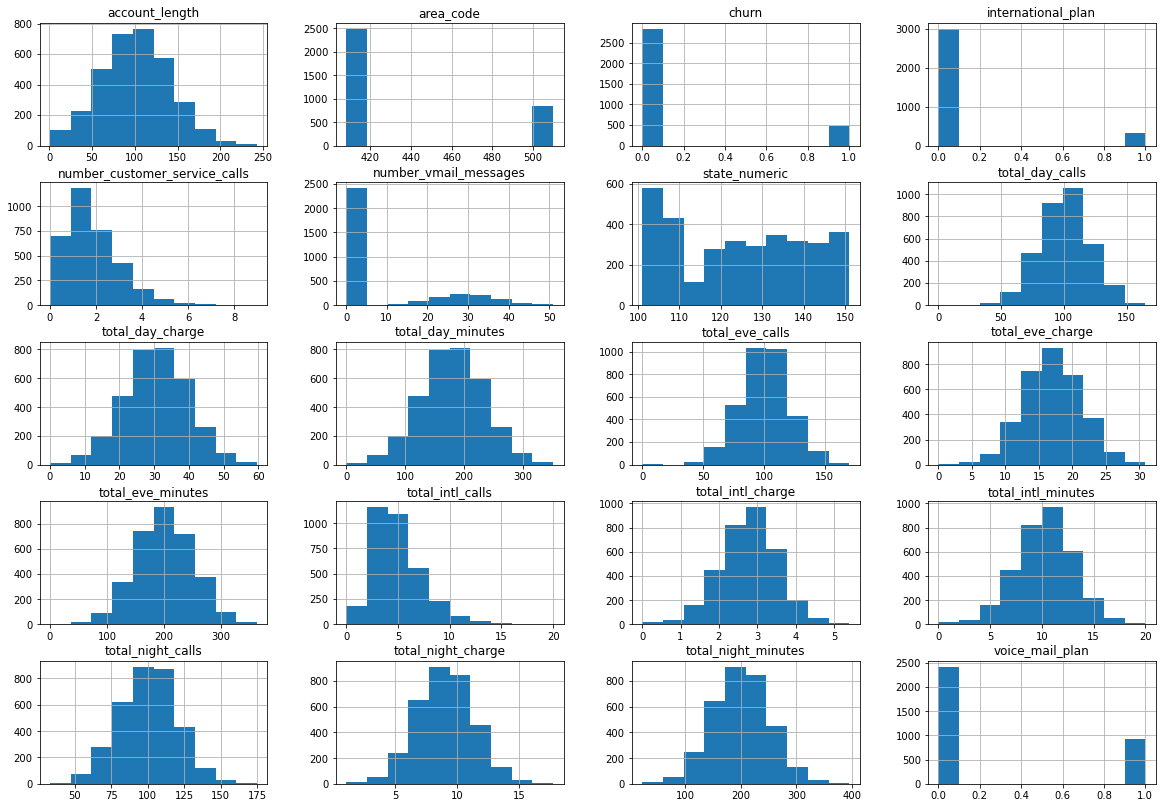

In [37]:
# Checagem da distribuição de cada variável
train.hist(figsize=(20,14)) 

In [ ]:
#Verificando o skew de cada atributo (coeficiente de simetria)
train.skew()

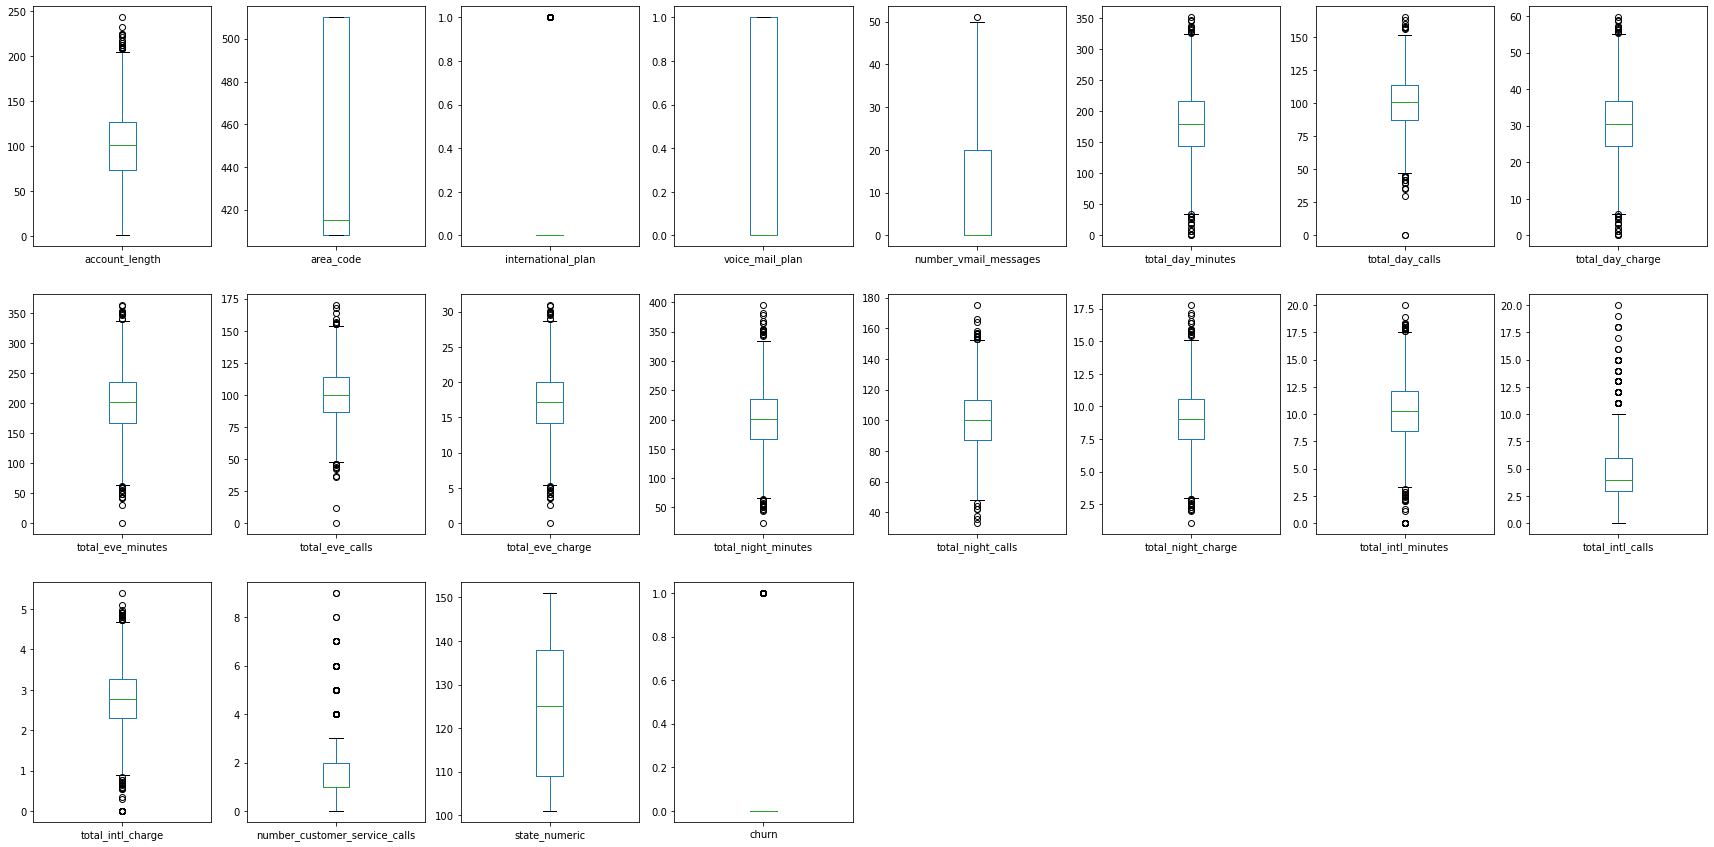

In [39]:
# Box and Whisker Plots
train.plot(kind = 'box', subplots = True, layout = (3,8), sharex = False, sharey = False, figsize=(30,15))
plt.show()

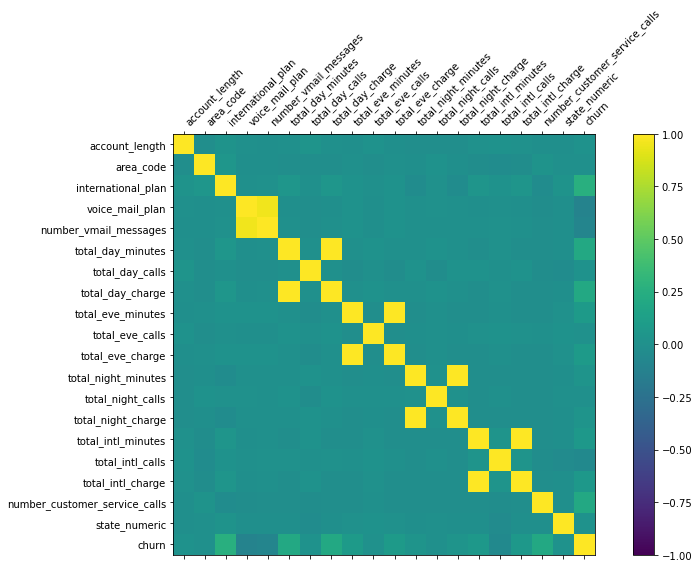

In [10]:
# Matriz de Correlação com nomes das variáveis
correlations = train.corr()

# Plot
import numpy as np
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 20, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(train.columns, rotation=45, horizontalalignment='left')
ax.set_yticklabels(train.columns)
fig.tight_layout()
plt.show()

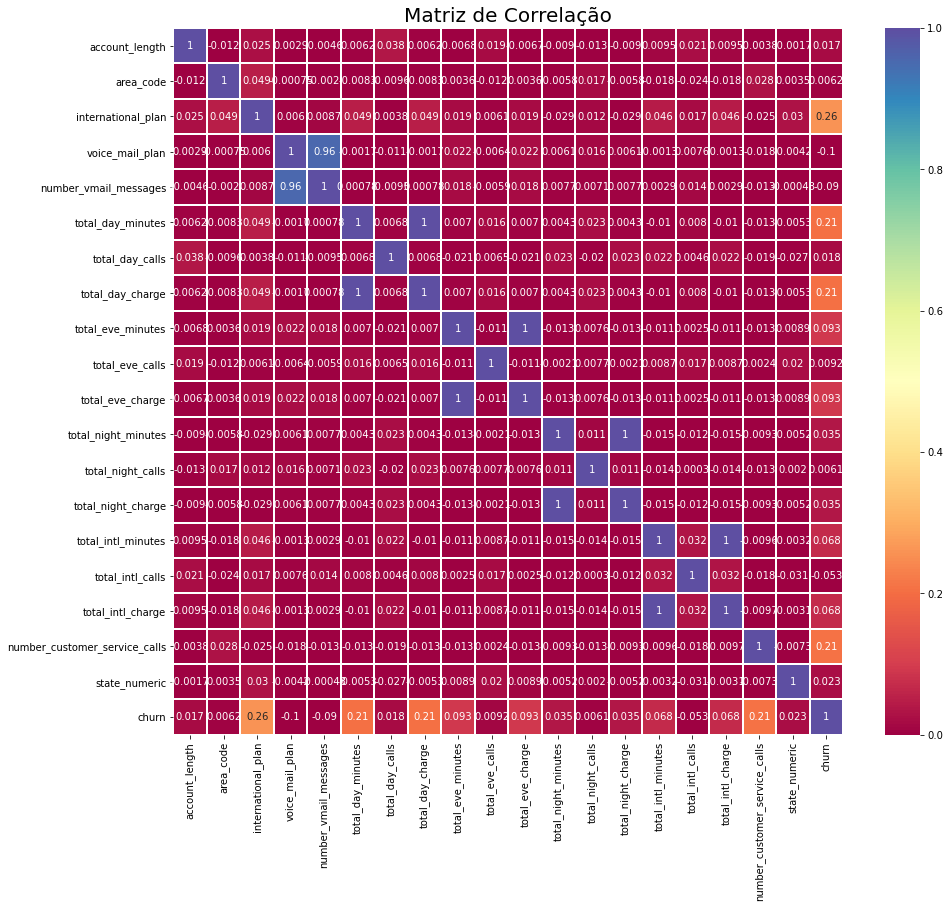

In [41]:

# Matriz de correlação
corr = pd.DataFrame(train, columns = train.columns).corr(method = 'pearson')

# Gráfico matriz de correlação
import seaborn as sns

fig, ax = plt.subplots(figsize = (15, 13))

sns.heatmap(corr, vmin = 0, vmax = 1, linewidths = 1, annot = True, cmap = 'Spectral')
ax.set_title('Matriz de Correlação', fontsize = 20)

plt.show()

In [42]:
# Explorando correlação entre variáveis preditoras e variável Target 'churn'
train.corr()['churn'].sort_values(ascending=False)

churn                            1.000000
international_plan               0.259852
number_customer_service_calls    0.208750
total_day_minutes                0.205151
total_day_charge                 0.205151
total_eve_minutes                0.092796
total_eve_charge                 0.092786
total_intl_charge                0.068259
total_intl_minutes               0.068239
total_night_charge               0.035496
total_night_minutes              0.035493
state_numeric                    0.023151
total_day_calls                  0.018459
account_length                   0.016541
total_eve_calls                  0.009233
area_code                        0.006174
total_night_calls                0.006141
total_intl_calls                -0.052844
number_vmail_messages           -0.089728
voice_mail_plan                 -0.102148
Name: churn, dtype: float64

### Primeiro Modelo - Sem tratamento

### Entendendo alguns conceitos:
> - **Cross Validation**: Faz a divisão do dataset em dados de treino e teste n vezes (kfolds) para que o algortimo possa conhecer mais dados e assim criar um algortimo mais confiável e que oferece maior acurácia, em contra partida, requer maior capacidade computacional.


In [138]:
from IPython.display import Image
img = Image(url = 'C:/Users/CintiaDuarte/Desktop/Projetos DS/Projeto4/imagem1.png')
display(img)

In [140]:
# Carregando os dados
array_train = train.values
array_test = test.values

# Separando o array em componentes de input e output
X_train = array_train[:, 0:19]
Y_train = array_train[:,19]

X_test = array_test[:, 0:19]
Y_test = array_test[:,19]


#### Regressão Logística

In [141]:
# Criação do modelo
modelo = LogisticRegression()

# Treinamento do modelo
modelo.fit(X_train, Y_train)

# Fazendo as previsões 
previsoes = modelo.predict(X_test)

#construindo a Confusion Matrix
matrix = confusion_matrix(Y_test, previsoes)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes) * 100))
print("Matrix de correlação: \n", matrix)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      1443
         1.0       0.66      0.11      0.19       224

    accuracy                           0.87      1667
   macro avg       0.77      0.55      0.56      1667
weighted avg       0.85      0.87      0.83      1667

Acurácia: 87.283
AUC: 55.130
Matrix de correlação: 
 [[1430   13]
 [ 199   25]]


#### Linear Discriminant Analysis

In [17]:
# Criação do modelo
modelo2 = LinearDiscriminantAnalysis()

# Treinamento do modelo
modelo2.fit(X_train, Y_train)

# Previsoes
previsoes2 = modelo2.predict(X_test)

#construindo a Confusion Matrix
matrix2 = confusion_matrix(Y_test, previsoes2)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes2))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes2) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes2) * 100))
print("Matrix de correlação: \n", matrix2)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      1443
         1.0       0.50      0.25      0.33       224

    accuracy                           0.87      1667
   macro avg       0.69      0.61      0.63      1667
weighted avg       0.84      0.87      0.85      1667

Acurácia: 86.503
AUC: 60.525
Matrix de correlação: 
 [[1386   57]
 [ 168   56]]


#### KNN - K-Neares Neighboars

In [19]:
# Criação do modelo
modelo3 = KNeighborsClassifier()

# Treinamento do modelo
modelo3.fit(X_train, Y_train)

# Previsoes
previsoes3 = modelo3.predict(X_test)

#construindo a Confusion Matrix
matrix3 = confusion_matrix(Y_test, previsoes3)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes3))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes3) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes3) * 100))
print("Matrix de correlação: \n", matrix3)


Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.89      0.98      0.94      1443
         1.0       0.69      0.25      0.37       224

    accuracy                           0.88      1667
   macro avg       0.79      0.62      0.65      1667
weighted avg       0.87      0.88      0.86      1667

Acurácia: 88.422
AUC: 61.634
Matrix de correlação: 
 [[1418   25]
 [ 168   56]]


#### Naive Bayes

In [20]:
# Criação do modelo
modelo4 = GaussianNB()

# Treinamento do modelo
modelo4.fit(X_train, Y_train)

# Previsoes
previsoes4 = modelo4.predict(X_test)

#construindo a Confusion Matrix
matrix4 = confusion_matrix(Y_test, previsoes4)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes4))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes4) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes4) * 100))
print("Matrix de correlação: \n", matrix4)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      1443
         1.0       0.53      0.51      0.52       224

    accuracy                           0.87      1667
   macro avg       0.73      0.72      0.72      1667
weighted avg       0.87      0.87      0.87      1667

Acurácia: 87.343
AUC: 71.947
Matrix de correlação: 
 [[1342  101]
 [ 110  114]]


#### CART (Classification and Regression Trees)

In [21]:
# Criação do modelo
modelo5 = DecisionTreeClassifier()

# Treinamento do modelo
modelo5.fit(X_train, Y_train)

# Previsoes
previsoes5 = modelo5.predict(X_test)

#construindo a Confusion Matrix
matrix5 = confusion_matrix(Y_test, previsoes5)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes5))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes5) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes5) * 100))
print("Matrix de correlação: \n", matrix5)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      1443
         1.0       0.64      0.69      0.67       224

    accuracy                           0.91      1667
   macro avg       0.80      0.82      0.81      1667
weighted avg       0.91      0.91      0.91      1667

Acurácia: 90.642
AUC: 81.584
Matrix de correlação: 
 [[1356   87]
 [  69  155]]


#### SVM - Support Vector Machines

In [22]:
# Criação do modelo
modelo6 = SVC()

# Treinamento do modelo
modelo6.fit(X_train, Y_train)

# Previsoes
previsoes6 = modelo6.predict(X_test)

#construindo a Confusion Matrix
matrix6 = confusion_matrix(Y_test, previsoes6)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes6))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes6) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes6) * 100))
print("Matrix de correlação: \n", matrix6)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1443
         1.0       0.00      0.00      0.00       224

    accuracy                           0.87      1667
   macro avg       0.43      0.50      0.46      1667
weighted avg       0.75      0.87      0.80      1667

Acurácia: 86.563
AUC: 50.000
Matrix de correlação: 
 [[1443    0]
 [ 224    0]]


#### Random Forest

In [25]:
# Criação do modelo
modelo7 = RandomForestClassifier()

# Treinamento do modelo
modelo7.fit(X_train, Y_train)

# Previsoes
previsoes7 = modelo6.predict(X_test)

#construindo a Confusion Matrix
matrix7 = confusion_matrix(Y_test, previsoes7)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes7))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes7) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes7) * 100))
print("Matrix de correlação: \n", matrix7)


Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1443
         1.0       0.00      0.00      0.00       224

    accuracy                           0.87      1667
   macro avg       0.43      0.50      0.46      1667
weighted avg       0.75      0.87      0.80      1667

Acurácia: 86.563
AUC: 50.000
Matrix de correlação: 
 [[1443    0]
 [ 224    0]]


### Feature Selection - Retirada de atributos irrelevantes ou colineares

A etapa de Feature Selection é onde selecionamos os atributos (variáveis) que serão melhores candidatas a variáveis preditoras. O Feature Selection nos ajuda a reduzir o overfitting (quando o algoritmo aprende demais), aumenta a acurácia do modelo e reduz o tempo de treinamento.

Seleção Univariada - Chi2
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [28]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 #pelo teste Q² 

X = train.iloc[:,0:19]
Y = train.iloc[:,19]

selector = SelectKBest(chi2, k = 10)

#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(X,Y)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                      Feat_names     F_Scores
4              total_day_minutes  2314.169315
3          number_vmail_messages   620.628799
5               total_day_charge   393.399658
6              total_eve_minutes   367.164781
1             international_plan   203.244178
9  number_customer_service_calls   160.773588
8            total_night_minutes    53.446506
7               total_eve_charge    31.201931
2                voice_mail_plan    25.156959
0                 account_length    14.304197


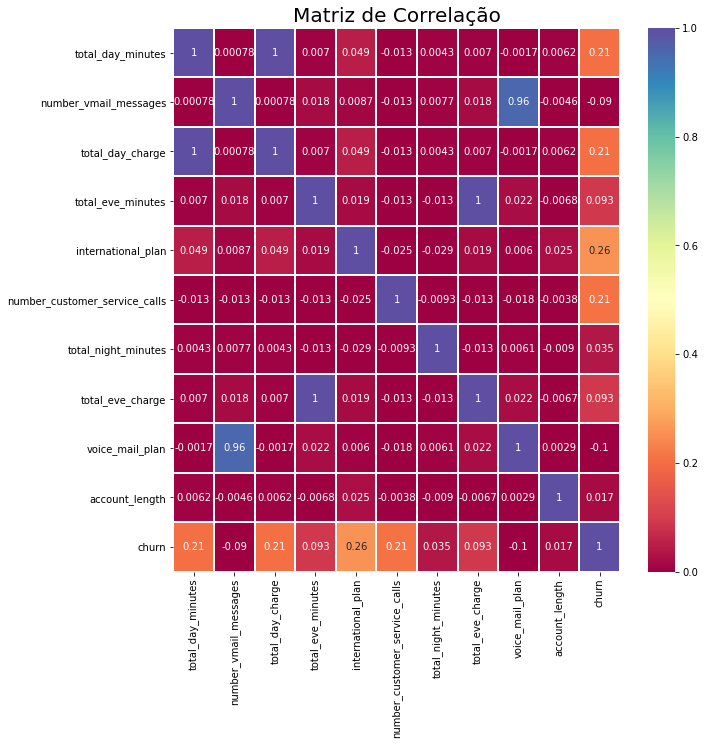

In [29]:
colunas = ns_df_sorted['Feat_names'].values
coluna_churn = np.array(['churn'])
colunas = np.concatenate((colunas, coluna_churn), axis=0)

# Matriz de correlação
corr = pd.DataFrame(train, columns = colunas).corr(method = 'pearson')

# Gráfico matriz de correlação
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(corr, vmin = 0, vmax = 1, linewidths = 1, annot = True, cmap = 'Spectral')
ax.set_title('Matriz de Correlação', fontsize = 20)

plt.show()

Seleção Univariada - f_classif

In [31]:
array = train.values

X = train.iloc[:,0:19]
Y = train.iloc[:,19]
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(f_classif, k = 10)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(X,Y)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted2 = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted2)

                      Feat_names    F_Scores
0             international_plan  241.206004
9  number_customer_service_calls  151.767013
3              total_day_minutes  146.350785
4               total_day_charge  146.350657
1                voice_mail_plan   35.122944
5              total_eve_minutes   28.932577
6               total_eve_charge   28.926444
2          number_vmail_messages   27.035912
8              total_intl_charge   15.592581
7             total_intl_minutes   15.583468


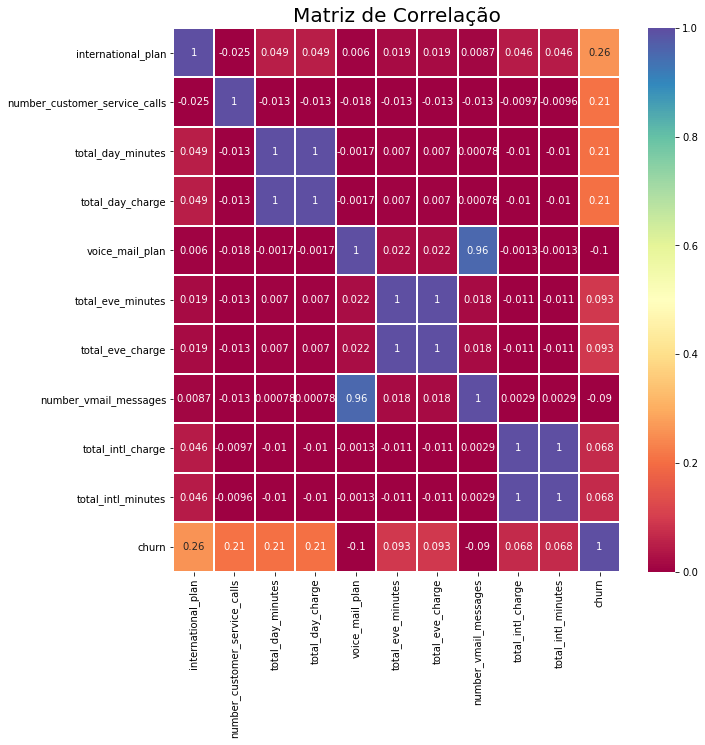

In [32]:
colunas = ns_df_sorted2['Feat_names'].values
coluna_churn = np.array(['churn'])
colunas = np.concatenate((colunas, coluna_churn), axis=0)

# Matriz de correlação
corr = pd.DataFrame(train, columns = colunas).corr(method = 'pearson')

# Gráfico matriz de correlação
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(corr, vmin = 0, vmax = 1, linewidths = 1, annot = True, cmap = 'Spectral')
ax.set_title('Matriz de Correlação', fontsize = 20)

plt.show()

RFE - Elimanação Recursiva de Atributos
- Esta é outra técnica para seleção de atributos, que recursivamente remove os atributos e constrói o modelo com os atributos remanescentes. Esta técnica utiliza a acurácia do modelo para identificar os atributos que mais contribuem para prever a variável alvo. Em inglês esta técnia é chamada Recursive Feature Elimination (RFE).
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Separando o array em componentes de input e output
array = train.values

X = array[:, 0:19]
Y = array[:,19]
# Criação do modelo
modelo = LogisticRegression()

# RFE
rfe = RFE(modelo, 10)
fit = rfe.fit(X, Y)

# Print dos resultados
#print("Variáveis Preditoras:", train.columns[0:10])
#print("Número de Melhores Atributos: %d" % fit.n_features_)

print("Variáveis Selecionadas: %s" % fit.support_)
print("Ranking dos Atributos: %s" % fit.ranking_)



Variáveis Selecionadas: [False False  True  True  True  True False False False  True False False
 False False  True  True  True  True  True]
Ranking dos Atributos: [ 9  2  1  1  1  1  5  6  4  1  8  7  3 10  1  1  1  1  1]


In [35]:
####### Eliminação Recursiva de Variáveis


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Separando o array em componentes de input e output
array = train.values

X = array[:, 0:19]
Y = array[:,19]
# Criação do modelo
modelo = LogisticRegression()

# RFE
rfe = RFE(modelo, 10)
fit = rfe.fit(X, Y)

# Print dos resultados
#print("Variáveis Preditoras:", train.columns[0:8])
#print("Variáveis Selecionadas: %s" % fit.support_)
#print("Ranking dos Atributos: %s" % fit.ranking_)
#print("Número de Melhores Atributos: %d" % fit.n_features_)


# Print dos resultados
print("Ranking dos Atributos: %s" % fit.ranking_)
#print("Número de Melhores Atributos: %d \n" % fit.n_features_)

features_col_index = []
index = 0

for i in fit.support_:
    if i == True:
        features_col_index.append(index)
    index += 1
features_col_index

features_col = train.columns[features_col_index].values

print('As features escolhidas pela RFE estão nas colunas de posição: \n', features_col_index)
print('\nAs features escolhidas pela RFE foram: \n', features_col)



Ranking dos Atributos: [ 9  2  1  1  1  1  5  6  4  1  8  7  3 10  1  1  1  1  1]
As features escolhidas pela RFE estão nas colunas de posição: 
 [2, 3, 4, 5, 9, 14, 15, 16, 17, 18]

As features escolhidas pela RFE foram: 
 ['international_plan' 'voice_mail_plan' 'number_vmail_messages'
 'total_day_minutes' 'total_eve_calls' 'total_intl_minutes'
 'total_intl_calls' 'total_intl_charge' 'number_customer_service_calls'
 'state_numeric']


Método Ensemble para Seleção de variáveis 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
- conceito de entropia

In [37]:
# Importância do Atributo com o Extra Trees Classifier

# Import dos Módulos
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

# Separando o array em componentes de input e output
array = train.values

X = array[:, 0:19]
Y = array[:,19]

# Criação do Modelo - Feature Selection
modelo8 = ExtraTreesClassifier()
modelo8.fit(X, Y)

# Print dos Resultados
print(train.columns[0:19])
print(modelo8.feature_importances_)

Index(['account_length', 'area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'state_numeric'],
      dtype='object')
[0.03512065 0.02238238 0.07342127 0.02150837 0.01868844 0.11960563
 0.03572033 0.12640309 0.05237159 0.03286214 0.05676155 0.03796005
 0.03406094 0.03714167 0.0441154  0.05161013 0.04463451 0.11968557
 0.03594629]


### Pré Processamento

In [142]:
#Reordernando o dataframe passando as variáveis binárias para o final para ficar mais fácil ao fazer a normalização

ordenacao = ['account_length',  'area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls',\
 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'state_numeric', 'international_plan' ,'voice_mail_plan' ,  'churn']

train_reordered = train[ordenacao]


#### Resample - Balanceamento de classes 

In [143]:
#Verificação a distribuição das classes
train_reordered.groupby('churn').size()


#observa-se que a classe 1 é consideravelmente menor do que a classe 0, portanto as classes estão desbalanceadas 

churn
0    2850
1     483
dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

balancer = SMOTE()
data_stardard, target_balancer = balancer.fit_resample(data_stardard, target)

In [144]:
from sklearn.utils import resample

#Sepação das classes
not_churn = train_reordered[train.churn==0] 
churn = train_reordered[train.churn==1]

#Aplicação resample
churn_resample = resample(churn, replace = True, n_samples=len(not_churn) ) 

train_resample = pd.concat([not_churn, churn_resample])

#Checando o novo shape das classes
train_resample.groupby('churn').size() 



churn
0    2850
1    2850
dtype: int64

In [145]:
# Separando o array em componentes de input e output
array_resample = train_resample.values

X_resample = array_resample[:, 0:19]
Y_resample = array_resample[:,19]

# Criação do modelo
modelo9 = LogisticRegression()

# Treinamento do modelo
modelo9.fit(X_resample, Y_resample)

# Fazendo as previsões 
previsoes9 = modelo9.predict(X_test)

#construindo a Confusion Matrix
matrix9 = confusion_matrix(Y_test, previsoes9)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes9))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes9) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes9) * 100))
print("Matrix de correlação: \n", matrix9)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.01      1443
         1.0       0.13      1.00      0.24       224

    accuracy                           0.14      1667
   macro avg       0.57      0.50      0.12      1667
weighted avg       0.88      0.14      0.04      1667

Acurácia: 13.797
AUC: 50.208
Matrix de correlação: 
 [[   6 1437]
 [   0  224]]


#### Normalização
Colocar os dados em uma escala com range entre 0 e 1. Isso é útil para a otimização, sendo usado no core dos algoritmos de Machine Learning, como gradient descent. Isso também é útil para algoritmos como regressão e redes neurais e algoritmos que usam medidas de distância, como KNN. O scikit-learn possui uma função para esta etapa, chamada MinMaxScaler().

In [158]:
#Normalização das variáveis numéricas (quantitativas)
#Normalização significa colocar os dados em uma escala com range entre 0 e 1

# Transformando os dados para a mesma escala (entre 0 e 1)

from sklearn.preprocessing import MinMaxScaler

array1 = train_resample.values
array2 = test.values

# Separando o array em componentes de input (X) e output (Y)
X_train = array1[:,0:19] ##variáveis preditoras 
X_test = array2[:,0:19]

# Gerando a nova escala (normalizando os dados)
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX_train = scaler.fit_transform(X_train) 
rescaledX_test = scaler.fit_transform(X_test) 

# Sumarizando os dados transformados
print("Dados Originais: \n\n", train_resample.values)
print("\nDados Normalizados: \n\n", rescaledX_train)


Dados Originais: 

 [[128. 415.  25. ...   0.   1.   0.]
 [107. 415.  26. ...   0.   1.   0.]
 [137. 415.   0. ...   0.   0.   0.]
 ...
 [ 52. 415.   0. ...   0.   0.   1.]
 [ 97. 510.   0. ...   0.   0.   1.]
 [ 65. 415.   0. ...   0.   0.   1.]]

Dados Normalizados: 

 [[0.52479339 0.06862745 0.49019608 ... 0.         0.         1.        ]
 [0.43801653 0.06862745 0.50980392 ... 0.02       0.         1.        ]
 [0.56198347 0.06862745 0.         ... 0.04       0.         0.        ]
 ...
 [0.2107438  0.06862745 0.         ... 0.34       0.         0.        ]
 [0.39669421 1.         0.         ... 0.9        0.         0.        ]
 [0.26446281 0.06862745 0.         ... 0.18       0.         0.        ]]


In [159]:
# Separando o array em componentes de input e output
array_resample = train_resample.values
test = test.values 

# Separando o array em componentes de input e output
X_train_rescaled = rescaledX_train
Y_train_rescaled = array_resample[:,19]

X_test_rescaled = rescaledX_test
Y_test_rescaled = test[:,19]

# Criação do modelo
modelo10 = LogisticRegression()

# Treinamento do modelo
modelo10.fit(X_train_rescaled, Y_train_rescaled)

# Fazendo as previsões 
previsoes10 = modelo10.predict(X_test_rescaled)

#construindo a Confusion Matrix
matrix10 = confusion_matrix(Y_test_rescaled, previsoes10)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test_rescaled, previsoes10))
print("Acurácia: %.3f" % (accuracy_score(Y_test_rescaled, previsoes10) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test_rescaled, previsoes10) * 100))
print("Matrix de correlação: \n", matrix10)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.86      1443
         1.0       0.18      0.22      0.20       224

    accuracy                           0.76      1667
   macro avg       0.53      0.53      0.53      1667
weighted avg       0.78      0.76      0.77      1667

Acurácia: 75.705
AUC: 53.157
Matrix de correlação: 
 [[1212  231]
 [ 174   50]]


In [147]:
#Concatenando as variáveis preditoras normalizadas com a variável target e transformando em um dataframe novo

df_train_rescaled = pd.concat([pd.DataFrame(rescaledX_train), pd.DataFrame(train_resample.iloc[:, 17:20].values)], axis = 1, ignore_index = False)
df_test_rescaled = pd.concat([pd.DataFrame(rescaledX_test), pd.DataFrame(test.iloc[:, 17:20].values)], axis = 1, ignore_index = False) 

df_train_rescaled.columns = train_resample.columns
df_test_rescaled.columns = test.columns

In [154]:
# Carregando os dados
array_train_rescaled = df_train_rescaled.values
array_test_rescaled = df_test_rescaled.values

# Separando o array em componentes de input e output
X_train_rescaled = array_train_rescaled[:, 0:19]
Y_train_rescaled = array_train_rescaled[:,19]

X_test_rescaled = array_test_rescaled[:, 0:19]
Y_test_rescaled = array_test_rescaled[:,19]

# Criação do modelo
modelo10 = LogisticRegression()

# Treinamento do modelo
modelo10.fit(X_train_rescaled, Y_train_rescaled)

# Fazendo as previsões 
previsoes10 = modelo10.predict(X_test_rescaled)

#construindo a Confusion Matrix
matrix10 = confusion_matrix(Y_test_rescaled, previsoes10)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test_rescaled, previsoes10))
print("Acurácia: %.3f" % (accuracy_score(Y_test_rescaled, previsoes10) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test_rescaled, previsoes10) * 100))
print("Matrix de correlação: \n", matrix10)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1443
         1.0       0.00      0.00      0.00       224

    accuracy                           0.87      1667
   macro avg       0.43      0.50      0.46      1667
weighted avg       0.75      0.87      0.80      1667

Acurácia: 86.563
AUC: 50.000
Matrix de correlação: 
 [[1443    0]
 [ 224    0]]


#### Padrinização
Padronização é a técnica para transformar os atributos com distribuição Gaussiana (normal) e diferentes médias e desvios padrão em uma distribuição Gaussiana com a média igual a 0 e desvio padrão igual a 1. Isso é útil para algoritmos que esperam que os dados estejam com uma distribuição Gaussiana, como regressão linear, regressão logística e linear discriminant analysis. 

In [124]:
#Padrinização não altera a distribução dos dados, coloca-os em uma distribuição normal.
# Padronizando os dados (0 para a média, 1 para o desvio padrão)

from sklearn.preprocessing import StandardScaler

# Gerando o novo padrão
scaler = StandardScaler().fit(rescaledX_train) 
standardX_train = scaler.transform(rescaledX_train)

scaler_test = StandardScaler().fit(rescaledX_test)
standardX_test = scaler.transform(rescaledX_test)

# Sumarizando os dados transformados
print("Dados Originais: \n\n", rescaledX_train)
print("\nDados Padronizados: \n\n", standardX_train)

Dados Originais: 

 [[0.52479339 0.06862745 0.49019608 ... 0.5        0.11111111 0.        ]
 [0.43801653 0.06862745 0.50980392 ... 0.68518519 0.11111111 0.02      ]
 [0.56198347 0.06862745 0.         ... 0.60925926 0.         0.04      ]
 ...
 [0.59917355 1.         0.         ... 0.19444444 0.44444444 0.06      ]
 [0.47107438 1.         0.         ... 0.59074074 0.11111111 0.02      ]
 [0.61570248 1.         0.         ... 0.69074074 0.44444444 0.34      ]]

Dados Padronizados: 

 [[ 0.67031048 -0.52354993  1.39410016 ... -0.15355816 -0.52167722
  -1.51170438]
 [ 0.13694237 -0.52354993  1.47083295 ...  1.18877465 -0.52167722
  -1.44829769]
 [ 0.89889682 -0.52354993 -0.52421957 ...  0.6384182  -1.13783143
  -1.38489101]
 ...
 [ 1.12748315  1.7160346  -0.52421957 ... -2.3684073   1.32678538
  -1.32148432]
 [ 0.34013022  1.7160346  -0.52421957 ...  0.50418491 -0.52167722
  -1.44829769]
 [ 1.22907707  1.7160346  -0.52421957 ...  1.22904463  1.32678538
  -0.43379072]]


In [125]:
#Concatenando as variáveis preditoras normalizadas com a variável target e transformando em um dataframe novo

df_train_standard = pd.concat([pd.DataFrame(standardX_train), pd.DataFrame(train_resample.iloc[:, 17:20].values)], axis = 1, ignore_index = False)
df_test_standard = pd.concat([pd.DataFrame(standardX_test), pd.DataFrame(test.iloc[:, 17:20].values)], axis = 1, ignore_index = False) 

df_train_standard.columns = train_resample.columns
df_test_standard.columns = test.columns

In [130]:
# Carregando os dados
array_train_standard = df_train_standard.values
array_test_standard = df_test_standard.values

# Separando o array em componentes de input e output
X_train_standard = array_train_standard[:, 0:19]
Y_train_standard = array_train_standard[:,19]

X_test_standard = array_test_standard[:, 0:19]
Y_test_standard = array_test_standard[:,19]

# Criação do modelo
modelo11 = LogisticRegression()

# Treinamento do modelo
modelo11.fit(X_train_standard, Y_train_standard)

# Fazendo as previsões 
previsoes11 = modelo11.predict(X_test)

#construindo a Confusion Matrix
matrix11 = confusion_matrix(Y_test, previsoes11)

# Relatório de classificação
print('Relatório de Classificação:\n', classification_report(Y_test, previsoes11))
print("Acurácia: %.3f" % (accuracy_score(Y_test, previsoes11) * 100))
print('AUC: %.3f' % (roc_auc_score(Y_test, previsoes11) * 100))
print("Matrix de correlação: \n", matrix11)

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      1443
         1.0       0.62      0.06      0.11       224

    accuracy                           0.87      1667
   macro avg       0.75      0.53      0.52      1667
weighted avg       0.84      0.87      0.82      1667

Acurácia: 86.863
AUC: 52.625
Matrix de correlação: 
 [[1435    8]
 [ 211   13]]


#### Redução de Dimensionalida - Feature Extraction
#### Principal Component Analysis (PCA) 

In [ ]:
# Feature Extraction

# Import dos módulos
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Carregando os dados
arquivo = 'data/pima-data.csv'
colunas = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dados = read_csv(arquivo, names = colunas)
array = dados.values

# Separando o array em componentes de input e output
X = array[:,0:8]
Y = array[:,8]

# Normalizando os dados
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X)

# Seleção de atributos
pca = PCA(n_components = 4)
fit = pca.fit(rescaledX)

# Sumarizando os componentes
print("Variância: %s" % fit.explained_variance_ratio_)
print(fit.components_)

### Criaçãdo do Modelo

In [ ]:
- Outlier
- rodar modelos e plotar resultado: curva ROC
- documentar tecnicamente 
- pipeline
- docker 
- airflow/mlflow
- git 